# RSA Analysis

In [24]:
import numpy as np

import torch
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

from src.dataset.kay import load_dataset
from src.ml.dataset import StimulusDataset, FMRIDataset
from src.ml.model import StimulusClassifier, FMRIClassifier
from src.ml import StimulusClassifierConfig, FMRIClassifierConfig
from src.utils.util import prepare_stimulus_data, prepare_fmri_data

In [26]:
%matplotlib inline
sns.set_style("darkgrid")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

## Load Model Configuration

In [2]:
config_stim = StimulusClassifierConfig()
config_fmri = FMRIClassifierConfig()

## Load Data

In [3]:
all_data = load_dataset(data_path="./../data/")

x_stim, y_stim = prepare_stimulus_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config_stim.class_ignore_list,
    label_level=config_stim.label_level,
)

x_fmri, y_fmri = prepare_fmri_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config_fmri.class_ignore_list,
    label_level=config_fmri.label_level,
    roi_select_list=config_fmri.roi_select_list,
)

x_stim.shape, y_stim.shape, x_fmri.shape, y_fmri.shape

((119, 128, 128), (119,), (119, 8427), (119,))

In [4]:
assert len(np.unique(y_stim)) == len(np.unique(y_fmri))
class2idx = {k: i for i, k in enumerate(np.unique(y_stim))}
idx2class = {v: k for k, v in class2idx.items()}

In [5]:
stim_dataset = StimulusDataset(
    x_data=x_stim,
    y_data=y_stim,
    img_transform=config_stim.img_transform["test"],
    class2idx=class2idx,
)

stim_loader = DataLoader(dataset=stim_dataset, shuffle=False, batch_size=1)


fmri_dataset = FMRIDataset(x_data=x_fmri, y_data=y_fmri, class2idx=class2idx)

fmri_loader = DataLoader(dataset=fmri_dataset, shuffle=False, batch_size=1)

## Load Model

In [6]:
stim_model = StimulusClassifier(
    num_channel=config_stim.model_input_num_channel, num_classes=len(class2idx)
)
stim_model.load_state_dict(
    torch.load("./../models/stimulus_classifier/stim_classifier_model.pth")
)
stim_model.eval()


fmri_model = FMRIClassifier(num_features=x_fmri.shape[1], num_classes=len(class2idx))
fmri_model.load_state_dict(
    torch.load("./../models/fmri_classifier/fmri_classifier_model.pth")
)
fmri_model.eval()

print("Models loaded.")

Models loaded.


## RSA

In [7]:
hidden_stim_dict = {k: [] for k in class2idx.keys()}
hidden_fmri_dict = {k: [] for k in class2idx.keys()}

with torch.no_grad():
    for x, y in stim_loader:
        hidden_stim = stim_model.get_latent_rep(x).squeeze()
        hidden_stim_dict[idx2class[y.item()]].append(hidden_stim)

with torch.no_grad():
    for x, y in fmri_loader:
        hidden_fmri = fmri_model.get_latent_rep(x).squeeze()
        hidden_fmri_dict[idx2class[y.item()]].append(hidden_fmri)

/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
hidden_stim_dict = {
    k: torch.stack(hidden_stim_dict[k], dim=0).mean(dim=(0, 1))
    for k in hidden_stim_dict.keys()
}

hidden_fmri_dict = {
    k: torch.stack(hidden_fmri_dict[k], dim=0).mean(dim=(0, 1))
    for k in hidden_fmri_dict.keys()
}

In [9]:
hidden_stim_dict, hidden_fmri_dict

({'animal': tensor(-0.2382),
  'artifact': tensor(-0.2393),
  'entity': tensor(-0.1977),
  'fruit': tensor(-0.1596),
  'geological formation': tensor(-0.1811)},
 {'animal': tensor(0.1454),
  'artifact': tensor(0.1537),
  'entity': tensor(0.2152),
  'fruit': tensor(0.1747),
  'geological formation': tensor(0.1981)})

In [10]:
hidden_stim_tensors = torch.stack(list(hidden_stim_dict.values()))
hidden_fmri_tensors = torch.stack(list(hidden_fmri_dict.values()))

In [11]:
rsa_matrix = hidden_stim_tensors.unsqueeze(0).T @ hidden_fmri_tensors.unsqueeze(0)

Text(29.999999999999993, 0.5, 'CNN Model')

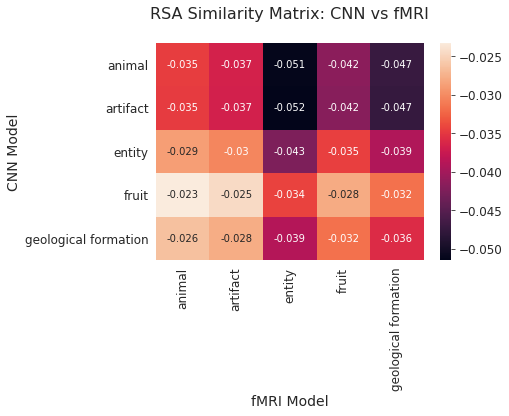

In [36]:
sns.heatmap(
    np.array(rsa_matrix),
    annot=True,
    xticklabels=class2idx.keys(),
    yticklabels=class2idx.keys(),
)
plt.title("RSA Similarity Matrix: CNN vs fMRI")
plt.xlabel("fMRI Model")
plt.ylabel("CNN Model")